# Imports

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from datetime import datetime
from scipy.optimize import newton, brentq, fsolve
from scipy.interpolate import interp1d
from scipy import interpolate
from datetime import datetime
import matplotlib.pyplot as plt

# Read in Data

In [91]:
# Read in Data
long_bonds = pd.read_csv('BondPrices(1).csv', skiprows=1, nrows=19) # Split 3-10 year bonds
short_bonds = pd.read_csv('BondPrices(1).csv', skiprows=23) # Split 0-3 year bonds

# Clean Data and Set Consistent Format
for df in [long_bonds, short_bonds]:
    df['Issue Date'] = pd.to_datetime(df['Issue Date'])
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])
    df['Coupon'] = df['Coupon'].astype(float)
    price_cols = [col for col in df.columns if 'Jan' in col]
    df[price_cols] = df[price_cols].replace('#VALUE!', np.nan).astype(float) # Replace with null values
    
# Set index to ISIN values
long_bonds.set_index('ISIN', inplace=True)
short_bonds.set_index('ISIN', inplace=True)

print("Long bonds shape:", long_bonds.shape)
print("Short bonds shape:", short_bonds.shape)
print("Short bonds first few rows:\n", short_bonds.head())

Long bonds shape: (19, 13)
Short bonds shape: (24, 13)
Short bonds first few rows:
              Issue Date  Coupon Maturity Date    Jan 6    Jan 7    Jan 8  \
ISIN                                                                       
CA135087M847 2021-10-15  0.0125    2027-03-01   96.660   96.635   96.605   
CA135087VW17 1996-05-01  0.0800    2027-06-01  111.870  111.895  111.780   
CA135087R226 2023-11-01  0.0450    2026-02-01  101.615  101.605  101.570   
CA135087N837 2022-05-13  0.0275    2027-09-01   99.675   99.655   99.550   
CA135087S398 2024-08-02  0.0325    2026-11-01      NaN      NaN      NaN   

                Jan 9   Jan 10   Jan 13   Jan 14   Jan 15   Jan 16   Jan 17  
ISIN                                                                         
CA135087M847   96.585   96.625   96.375   96.265   96.195   96.375   96.615  
CA135087VW17  111.750  111.815  111.370  111.245  111.145  111.295  111.540  
CA135087R226  101.575  101.595  101.440  101.380  101.360  101.420  101

# Ten Bond Selection

In [92]:
ten_bonds = [
    'CA135087K528', 'CA135087K940', 'CA135087L518', 'CA135087L930',
    'CA135087M847', 'CA135087N837', 'CA135087P576', 'CA135087Q491',
    'CA135087Q988', 'CA135087R895'
]

# Maturities of selected bonds
selected_bonds = pd.concat([long_bonds, short_bonds]).loc[ten_bonds]
print("Selected 10 bond maturities:")
for isin in ten_bonds:
    maturity = selected_bonds.loc[isin, 'Maturity Date']
    print(f"{isin}: {maturity.strftime('%Y-%m-%d')}")

Selected 10 bond maturities:
CA135087K528: 2025-03-01
CA135087K940: 2025-09-01
CA135087L518: 2026-03-01
CA135087L930: 2026-09-01
CA135087M847: 2027-03-01
CA135087N837: 2027-09-01
CA135087P576: 2028-03-01
CA135087Q491: 2028-09-01
CA135087Q988: 2029-03-01
CA135087R895: 2029-09-01


# Yield Curve

In [93]:
def calc_dirty_price(clean_price, coupon, prev_payment, calc_date):
    """Calculate bond's dirty price by adding accrued interest to clean price.
    
    Args:
        clean_price: Clean bond price
        coupon: Annual coupon rate as decimal
        prev_payment: Previous coupon payment date
        calc_date: Calculation date
    
    Returns:
        Dirty price of the bond
    """
    days_since_payment = (calc_date - prev_payment).days
    accrued_interest = (days_since_payment / 365) * coupon * 100
    return clean_price + accrued_interest

def calc_ytm(price, par, coupon, maturity_date, calc_date, freq=2):
    """Calculate bond's yield to maturity using actual day count.
    
    Args:
        price: Clean bond price
        par: Par value
        coupon: Annual coupon rate as decimal
        maturity_date: Bond maturity date
        calc_date: Calculation date
        freq: Coupon payments per year
    
    Returns:
        Yield to maturity as decimal
    """
    if price <= 0:
        return np.nan

    # Calculate periods and cash flow dates
    periods = 0
    coupon_date = maturity_date
    while calc_date < coupon_date:
        coupon_date = coupon_date - pd.DateOffset(months=6)
        periods += 1
    
    # Semi-annual coupon payment
    coupon_payment = (coupon / freq) * par
    
    # Generate cash flows and payment dates
    cash_flows = [coupon_payment] * (periods - 1) + [coupon_payment + par]
    payment_dates = [coupon_date + (i+1)*pd.DateOffset(months=6) for i in range(periods)]
    
    # Calculate dirty price
    dirty_price = calc_dirty_price(price, coupon, coupon_date, calc_date)
    
    def ytm_equation(y):
        """Present value equation using actual days"""
        return sum([cf / (1 + y)**((date - calc_date).days / 365) 
                   for cf, date in zip(cash_flows, payment_dates)]) - dirty_price
    
    ytm_solution = fsolve(ytm_equation, x0=0.05)[0]
    return max(ytm_solution, 0)

def calculate_yield_curves(selected_bonds, ref_date=datetime(2025, 1, 6)): 
    """Calculate yield curves for multiple bonds across different dates.
    
    Args:
        selected_bonds: DataFrame with bond data (maturity, coupon, prices)
        ref_date: Reference date for calculations
    
    Returns:
        DataFrame with yield curves by date and maturity
    """
    price_dates = [col for col in selected_bonds.columns if 'Jan' in col]
    ytm_data = []

    for date in price_dates:
        ytms = {'Date': datetime.strptime(date, '%b %d').strftime('%b %d')}
        calc_date = datetime.strptime(f"2025 {date}", '%Y %b %d')
        
        for isin, bond in selected_bonds.iterrows():
            price = bond[date]
            if pd.isna(price) or price <= 0:
                continue
                
            maturity_date = bond['Maturity Date']
            if maturity_date <= calc_date:
                continue
                
            ytm = calc_ytm(price, 100, bond['Coupon'], maturity_date, calc_date)
            years_to_maturity = (maturity_date - calc_date).days / 365
            
            if not np.isnan(ytm):
                ytms[f"{int(years_to_maturity)}Y"] = round(ytm * 100, 4)
        
        if len(ytms) > 1:
            ytm_data.append(ytms)
            
    return pd.DataFrame(ytm_data).fillna('')

def plot_yield_curves(ytm_df):
    """Plot yield curves"""
    plt.figure(figsize=(16, 6))
    
    for _, row in ytm_df.iterrows():
        date = row['Date']
        maturities = [int(col[:-1]) for col in row.index if 'Y' in col]
        yields = [row[f"{m}Y"] for m in maturities]
        plt.plot(maturities, yields, marker='o', label=date)
    
    plt.title('Government of Canada Yield Curves')
    plt.xlabel('Years to Maturity')
    plt.ylabel('Yield to Maturity (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

For reference, a YTM curve plotted with interpolation method was also computed. The code is commented out for clarity

In [94]:
# def calc_dirty_price(clean_price, coupon, prev_payment, calc_date):
#     """Convert clean price to dirty price by adding accrued interest."""
#     days_since_payment = (calc_date - prev_payment).days
#     accrued_interest = (days_since_payment / 365) * coupon * 100
#     return clean_price + accrued_interest

# def calc_ytm(price, par, coupon, maturity_date, calc_date, freq=2):
#     """Calculate yield to maturity using actual day count."""
#     if price <= 0:
#         return np.nan

#     # Calculate periods and cash flow dates
#     periods = 0
#     coupon_date = maturity_date
#     while calc_date < coupon_date:
#         coupon_date = coupon_date - pd.DateOffset(months=6)
#         periods += 1
    
#     # Semi-annual coupon payment
#     coupon_payment = (coupon / freq) * par
    
#     # Generate cash flows and payment dates
#     cash_flows = [coupon_payment] * (periods - 1) + [coupon_payment + par]
#     payment_dates = [coupon_date + (i+1)*pd.DateOffset(months=6) for i in range(periods)]
    
#     # Calculate dirty price
#     dirty_price = calc_dirty_price(price, coupon, coupon_date, calc_date)
    
#     def ytm_equation(y):
#         """Present value equation using actual days."""
#         return sum([cf / (1 + y)**((date - calc_date).days / 365) 
#                    for cf, date in zip(cash_flows, payment_dates)]) - dirty_price
    
#     ytm_solution = fsolve(ytm_equation, x0=0.05)[0]
#     return max(ytm_solution, 0)

# def calculate_interpolated_yield_curves(selected_bonds, ref_date=datetime(2025, 1, 6)):
#     """Calculate yield curves using linear interpolation for standard intervals."""
#     price_dates = [col for col in selected_bonds.columns if 'Jan' in col]
#     ytm_data = []

#     for date in price_dates:
#         ytms = {'Date': datetime.strptime(date, '%b %d').strftime('%b %d')}
#         calc_date = datetime.strptime(f"2025 {date}", '%Y %b %d')
        
#         # Calculate YTM and exact maturity for each bond
#         maturities = []
#         rates = []
        
#         for isin, bond in selected_bonds.iterrows():
#             price = bond[date]
#             if pd.isna(price) or price <= 0:
#                 continue
                
#             maturity_date = bond['Maturity Date']
#             if maturity_date <= calc_date:
#                 continue
                
#             ytm = calc_ytm(price, 100, bond['Coupon'], maturity_date, calc_date)
#             years_to_maturity = (maturity_date - calc_date).days / 365
            
#             if not np.isnan(ytm):
#                 maturities.append(years_to_maturity)
#                 rates.append(ytm)
        
#         # Create interpolation function
#         if maturities and rates:
#             f = interp1d(maturities, rates, kind='linear', fill_value='extrapolate')
            
#             # Calculate rates at standard intervals
#             for year in range(1, 6):
#                 ytms[f"{year}Y"] = round(float(f(year)) * 100, 4)
        
#         ytm_data.append(ytms)
            
#     return pd.DataFrame(ytm_data).fillna('')

# # Calculate and display interpolated YTMs
# ytm_df = calculate_interpolated_yield_curves(selected_bonds)

# # Print results
# print("\nInterpolated YTM curves data:")
# print(ytm_df.to_string(index=False))

# # Print original YTMs for one date for comparison
# print("\nOriginal YTMs for Jan 6 (uninterpolated):")
# calc_date = datetime(2025, 1, 6)
# sorted_bonds = selected_bonds.sort_values('Maturity Date')
# for isin, bond in sorted_bonds.iterrows():
#     if bond['Maturity Date'] > calc_date:
#         ytm = calc_ytm(bond['Jan 6'], 100, bond['Coupon'], bond['Maturity Date'], calc_date)
#         years = (bond['Maturity Date'] - calc_date).days / 365
#         print(f"Years: {years:.4f}, YTM: {ytm*100:.4f}%")

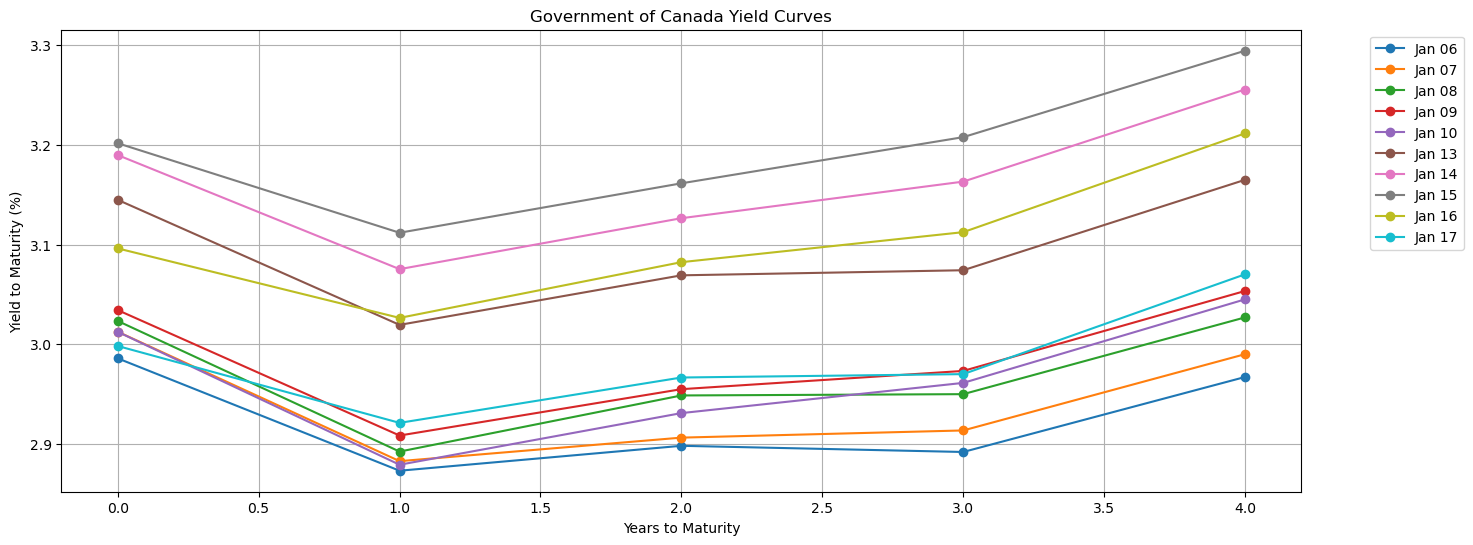

Yield curves data:
  Date     0Y     1Y     2Y     3Y     4Y
Jan 06 2.9859 2.8732 2.8982 2.8920 2.9672
Jan 07 3.0126 2.8828 2.9064 2.9136 2.9901
Jan 08 3.0234 2.8924 2.9487 2.9500 3.0270
Jan 09 3.0343 2.9085 2.9550 2.9733 3.0535
Jan 10 3.0125 2.8792 2.9310 2.9613 3.0451
Jan 13 3.1449 3.0195 3.0692 3.0743 3.1650
Jan 14 3.1898 3.0754 3.1265 3.1632 3.2556
Jan 15 3.2017 3.1119 3.1615 3.2078 3.2945
Jan 16 3.0962 3.0265 3.0824 3.1125 3.2116
Jan 17 2.9983 2.9212 2.9667 2.9701 3.0702


In [95]:
# Compute yield curves using already-selected bonds
ytm_df = calculate_yield_curves(selected_bonds)

# Plot yield curves
plot_yield_curves(ytm_df)

# Print formatted yield curve data
print("Yield curves data:")
print(ytm_df.to_string(index=False))

Print computed values for all dates and bonds as reference

In [96]:
# Create a DataFrame with ISIN index and dates as columns
ytm_detail_df = pd.DataFrame(index=selected_bonds.index)

# Calculate YTM for each bond and date
for date in [col for col in selected_bonds.columns if 'Jan' in col]:
    calc_date = datetime.strptime(f"2025 {date}", '%Y %b %d')
    ytms = []
    
    for isin, bond in selected_bonds.iterrows():
        price = bond[date]
        maturity_date = bond['Maturity Date']
        
        if pd.isna(price) or price <= 0 or maturity_date <= calc_date:
            ytms.append(np.nan)
        else:
            ytm = calc_ytm(price, 100, bond['Coupon'], maturity_date, calc_date)
            ytms.append(ytm * 100)  # Convert to percentage
            
    ytm_detail_df[date] = ytms

# Add maturity date and coupon columns for reference
ytm_detail_df['Maturity'] = selected_bonds['Maturity Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
ytm_detail_df['Coupon'] = selected_bonds['Coupon']

# Sort by maturity date
ytm_detail_df = ytm_detail_df.sort_values('Maturity')

# Print results
pd.set_option('display.float_format', '{:.4f}'.format)
print("\nYield to Maturity (%) for each bond and date:")
print(ytm_detail_df.to_string())
pd.reset_option('display.float_format')


Yield to Maturity (%) for each bond and date:
              Jan 6  Jan 7  Jan 8  Jan 9  Jan 10  Jan 13  Jan 14  Jan 15  Jan 16  Jan 17    Maturity  Coupon
ISIN                                                                                                        
CA135087K528 3.2156 3.2529 3.2555 3.1845  3.2235  3.3904  3.4373  3.4445  3.3664  3.0663  2025-03-01  0.0125
CA135087K940 2.9859 3.0126 3.0234 3.0343  3.0125  3.1449  3.1898  3.2017  3.0962  2.9983  2025-09-01  0.0050
CA135087L518 2.9626 2.9646 2.9898 2.9824  2.9751  3.0988  3.1484  3.1888  3.1200  2.9892  2026-03-01  0.0025
CA135087L930 2.8732 2.8828 2.8924 2.9085  2.8792  3.0195  3.0754  3.1119  3.0265  2.9212  2026-09-01  0.0100
CA135087M847 2.8870 2.9016 2.9187 2.9309  2.9129  3.0459  3.1042  3.1422  3.0529  2.9330  2027-03-01  0.0125
CA135087N837 2.8982 2.9064 2.9487 2.9550  2.9310  3.0692  3.1265  3.1615  3.0824  2.9667  2027-09-01  0.0275
CA135087P576 2.8679 2.8791 2.9138 2.9285  2.9095  3.0280  3.1160  3.1549  3.0745 

# Bootstrap Spot Curve

In [97]:
def find_dirty_price(price, coupon, maturity_date, calc_date):
    """Calculate bond's dirty price by adding accrued interest to clean price.
    
    Args:
        price: Clean bond price
        coupon: Annual coupon rate as decimal
        maturity_date: Bond maturity date
        calc_date: Calculation date
    
    Returns:
        Dirty price of the bond
    """
    last_coupon = maturity_date
    while calc_date < last_coupon:
        last_coupon = last_coupon - pd.DateOffset(months=6)
    
    days_since_last_coupon = (calc_date - last_coupon).days
    dirty_price = price + (days_since_last_coupon / 365) * coupon * 100
    return dirty_price

def bootstrap_spot_rates(bonds_df, calc_date, price_col):
    """Bootstrap spot rates from bond prices using iterative approach.
    
    Args:
        bonds_df: DataFrame with bond data (maturity, coupon, prices)
        calc_date: Calculation date
        price_col: Column name containing bond prices
    
    Returns:
        List of spot rates for each bond maturity
    """
    spot_rates = []
    bonds_df = bonds_df.sort_values('Maturity Date')
    
    for _, bond in bonds_df.iterrows():
        clean_price = bond[price_col]
        if pd.isna(clean_price):
            continue
            
        coupon = bond['Coupon']
        maturity = bond['Maturity Date']
        
        # Calculate dirty price
        dirty_price = find_dirty_price(clean_price, coupon, maturity, calc_date)
        
        # Adjust coupon to semi-annual payments
        semi_annual_coupon = coupon / 2 * 100
        
        # Calculate coupon dates and number of periods
        periods = 0
        coupon_date = maturity
        while calc_date < coupon_date:
            coupon_date = coupon_date - pd.DateOffset(months=6)
            periods += 1
            
        # Generate cash flow dates
        cash_flow_dates = [coupon_date + (i+1)*pd.DateOffset(months=6) for i in range(periods)]
        cash_flows = [semi_annual_coupon] * (periods - 1) + [semi_annual_coupon + 100]
        
        if len(spot_rates) == 0:
            # For first bond, solve directly
            time_to_maturity = (cash_flow_dates[0] - calc_date).days / 365
            spot_rate = ((100 + semi_annual_coupon) / dirty_price) ** (1 / time_to_maturity) - 1
            spot_rates.append(spot_rate)
        else:
            # Use previous spot rates to discount interim cash flows
            discounted_coupons = 0
            for t in range(min(periods-1, len(spot_rates))):
                time_to_cf = (cash_flow_dates[t] - calc_date).days / 365
                discounted_coupons += cash_flows[t] / (1 + spot_rates[t])**time_to_cf
            
            # Solve for the new spot rate
            time_to_maturity = (cash_flow_dates[periods-1] - calc_date).days / 365
            spot_rate = ((100 + semi_annual_coupon) / (dirty_price - discounted_coupons)) ** (1 / time_to_maturity) - 1
            spot_rates.append(spot_rate)
    
    return spot_rates

def calculate_spot_curves(selected_bonds):
    """Generate spot rate curves for each date in the dataset.
    
    Args:
        selected_bonds: DataFrame with bond data (maturity, coupon, prices by date)
    
    Returns:
        DataFrame with spot rates by date and maturity year
    """
    price_dates = [col for col in selected_bonds.columns if 'Jan' in col]
    spot_data = []
    
    for date_col in price_dates:
        calc_date = datetime.strptime(f"2025 {date_col}", '%Y %b %d')
        spots = {'Date': date_col}
        
        # Get spot rates for all bonds on this date
        daily_spot_rates = bootstrap_spot_rates(selected_bonds, calc_date, date_col)
        
        if daily_spot_rates:
            # Map spot rates to years based on time to maturity
            sorted_bonds = selected_bonds.sort_values('Maturity Date').reset_index(drop=True)
            for idx in range(len(sorted_bonds)):
                bond = sorted_bonds.iloc[idx]
                time_to_maturity = (bond['Maturity Date'] - calc_date).days / 365
                year = int(round(time_to_maturity))
                if 0 < year <= 5 and idx < len(daily_spot_rates):  # Only include rates for 1-5 years
                    spots[f"{year}Y"] = round(daily_spot_rates[idx] * 100, 4)
        
        spot_data.append(spots)
    
    return pd.DataFrame(spot_data)


def plot_spot_curve(spot_df):
    """Plot spot rate curves"""
    plt.figure(figsize=(16, 6))
    
    for _, row in spot_df.iterrows():
        date = row['Date']
        maturities = [int(col[:-1]) for col in row.index if 'Y' in col]
        rates = [row[col] for col in row.index if 'Y' in col]
        plt.plot(maturities, rates, marker='o', label=date)
    plt.xlabel("Years to Maturity")
    plt.ylabel("Spot Rate (%)")
    plt.title("Spot Rate Curve")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.show()


Spot curve data:
  Date     1Y     2Y     3Y     4Y     5Y
 Jan 6 2.9626 2.8864 2.8658 2.9365 2.9718
 Jan 7 2.9645 2.9011 2.8770 2.9595 2.9953
 Jan 8 2.9897 2.9183 2.9123 2.9992 3.0326
 Jan 9 2.9824 2.9306 2.9273 3.0265 3.0599
Jan 10 2.9750 2.9126 2.9083 3.0079 3.0522
Jan 13 3.0988 3.0455 3.0261 3.1280 3.1717
Jan 14 3.1484 3.1039 3.1157 3.2155 3.2636
Jan 15 3.1888 3.1420 3.1547 3.2625 3.3024
Jan 16 3.1200 3.0526 3.0745 3.1650 3.2199
Jan 17 2.9891 2.9327 2.9550 3.0457 3.0772


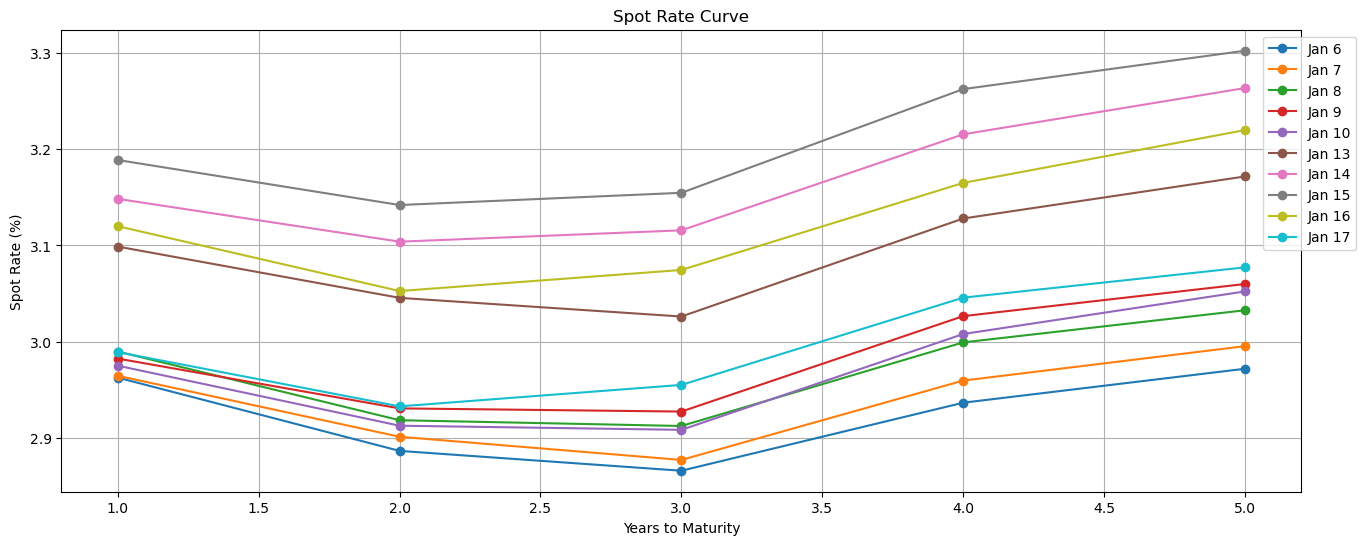

In [98]:
# Calculate and display the results
spot_df = calculate_spot_curves(selected_bonds)
print("\nSpot curve data:")
print(spot_df.to_string(index=False))

# Plot the curves
plot_spot_curve(spot_df)

In [99]:
def format_spot_rates_detail(selected_bonds, calc_date_str):
    """Format spot rates with linearly interpolated standard intervals"""
    calc_date = datetime.strptime(f"2025 {calc_date_str}", '%Y %b %d')
    
    # Sort bonds by maturity for bootstrapping
    sorted_bonds = selected_bonds.sort_values('Maturity Date')
    spot_rates = bootstrap_spot_rates(sorted_bonds, calc_date, calc_date_str)
    
    # Calculate exact maturity years
    maturity_years = [(bond['Maturity Date'] - calc_date).days / 365.0 
                     for _, bond in sorted_bonds.iterrows()]
    
    # Create linear interpolation function
    f = interp1d(maturity_years, spot_rates, kind='linear', fill_value='extrapolate')
    
    # Standard intervals from 0.5 to 5.0 years, stepping by 0.5
    standard_years = np.arange(0.5, 5.1, 0.5)
    interpolated_rates = f(standard_years)
    
    # Create DataFrame with the required format
    spot_data = {
        'date': [calc_date.strftime('%Y-%m-%d')] * len(standard_years),
        'maturity_years': standard_years,
        'spot': interpolated_rates
    }
    
    spot_df = pd.DataFrame(spot_data)
    return spot_df

# Calculate and display spot rates for Jan 6
jan6_spots = format_spot_rates_detail(selected_bonds, 'Jan 6')

# Set display options for clean output
pd.set_option('display.float_format', lambda x: '%.6f' % x)
print("\nLinearly interpolated spot rates at standard intervals:")
print(jan6_spots.to_string(index=True))

# Also print original values for comparison
print("\nOriginal spot rates before interpolation:")
calc_date = datetime(2025, 1, 6)
for isin, bond in selected_bonds.sort_values('Maturity Date').iterrows():
    years = (bond['Maturity Date'] - calc_date).days / 365.0
    price_col = 'Jan 6'
    spot_rate = bootstrap_spot_rates(selected_bonds, calc_date, price_col)[
        list(selected_bonds.index).index(isin)
    ]
    print(f"Years: {years:.4f}, Rate: {spot_rate:.6f}")


Linearly interpolated spot rates at standard intervals:
         date  maturity_years     spot
0  2025-01-06        0.500000 0.030551
1  2025-01-06        1.000000 0.029695
2  2025-01-06        1.500000 0.028997
3  2025-01-06        2.000000 0.028823
4  2025-01-06        2.500000 0.028942
5  2025-01-06        3.000000 0.028754
6  2025-01-06        3.500000 0.028837
7  2025-01-06        4.000000 0.029228
8  2025-01-06        4.500000 0.029610
9  2025-01-06        5.000000 0.029960

Original spot rates before interpolation:
Years: 0.1479, Rate: 0.032156
Years: 0.6521, Rate: 0.029858
Years: 1.1479, Rate: 0.029626
Years: 1.6521, Rate: 0.028725
Years: 2.1479, Rate: 0.028864
Years: 2.6521, Rate: 0.028976
Years: 3.1507, Rate: 0.028658
Years: 3.6548, Rate: 0.028915
Years: 4.1507, Rate: 0.029365
Years: 4.6548, Rate: 0.029718


# Forward Rate

In [100]:
def calculate_forward_rates(spot_df):
    """Calculate implied forward rates from spot rates curve.
   
   Args:
       spot_df: DataFrame with spot rates by date and maturity
   
   Returns:
       DataFrame with forward rates by date and period
   """
    forward_data = []
    
    for _, row in spot_df.iterrows():
        forwards = {'Date': row['Date']}
        
        # Calculate forward rates for 1yr to n-years
        for n in range(2, 6):
            if f"{n}Y" in row and "1Y" in row:
                spot_n = row[f"{n}Y"] / 100
                spot_1 = row["1Y"] / 100
                
                # Calculate forward rate using semi-annual compounding
                forward = ((1 + spot_n)**(2*n) / (1 + spot_1)**(2))**(1/(2*(n-1))) - 1
                forwards[f"1Y-{n-1}Y"] = round(forward * 100, 4)
        
        forward_data.append(forwards)
    
    return pd.DataFrame(forward_data)

def plot_forward_curve(forward_df):
    """Plot forward rate curves"""
    
    plt.figure(figsize=(16, 6))
    for _, row in forward_df.iterrows():
        date = row['Date']
        maturities = [int(col.split('-')[1][:-1]) for col in row.index if '1Y-' in col]
        rates = [row[col] for col in row.index if '1Y-' in col]
        plt.plot(maturities, rates, marker='o', label=date)
    plt.xlabel("Forward Period (Years)")
    plt.ylabel("Forward Rate (%)")
    plt.title("Forward Rate Curve")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.show()


Forward curve data:
  Date    1Y-1Y    1Y-2Y    1Y-3Y    1Y-4Y
 Jan 6 2.810300 2.817400 2.927800 2.974100
 Jan 7 2.837700 2.833300 2.957800 3.003000
 Jan 8 2.846900 2.873600 3.002400 3.043300
 Jan 9 2.878800 2.899800 3.041200 3.079300
Jan 10 2.850200 2.875000 3.018900 3.071500
Jan 13 2.992200 2.989800 3.137700 3.189900
Jan 14 3.059400 3.099400 3.237900 3.292400
Jan 15 3.095200 3.137700 3.287100 3.330800
Jan 16 2.985200 3.051800 3.180000 3.244900
Jan 17 2.876300 2.938000 3.064600 3.099200


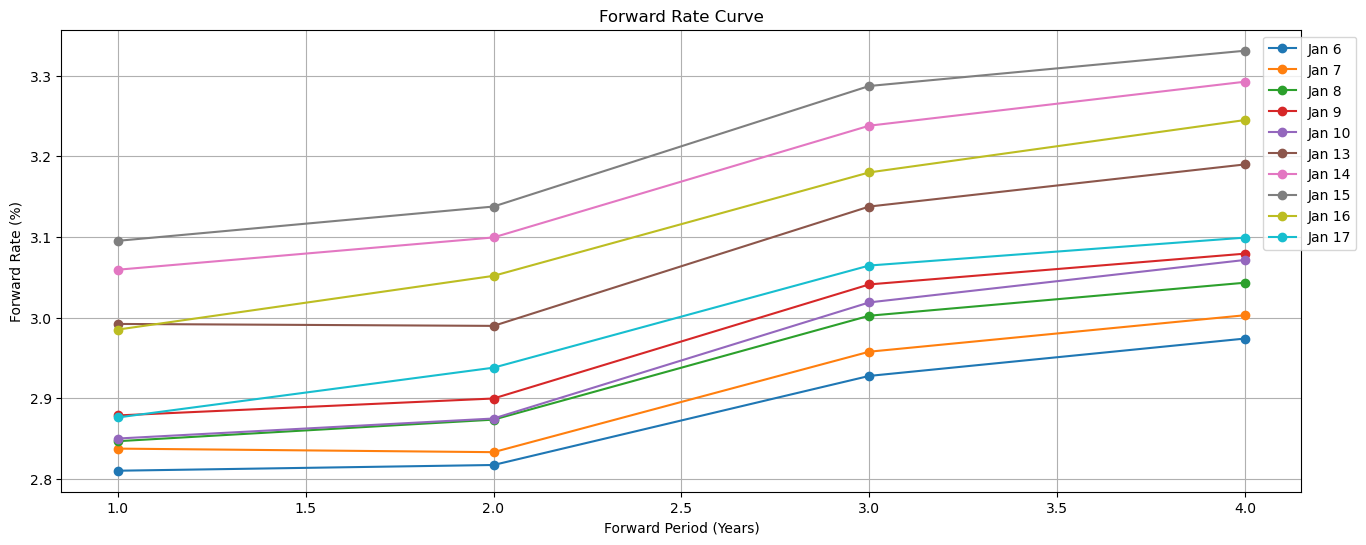

In [101]:
# Calculate and display the results
forward_df = calculate_forward_rates(spot_df)

print("\nForward curve data:")
print(forward_df.to_string(index=False))

# Plot the curves
plot_forward_curve(forward_df)

In [102]:
def format_forward_rates_detail(spot_df, calc_date_str='Jan 6'):
    """Format forward rates showing forward years and maturity years"""
    # Calculate forward rates from spot rates
    date_spot_rates = spot_df[spot_df['Date'] == calc_date_str].iloc[0]
    
    forward_data = {
        'date': [],
        'forward_years': [],
        'maturity_years': [],
        'forward_rate': []
    }
    
    # Calculate 1-year forward rates for 2,3,4,5 year maturities
    for n in range(2, 6):
        if f"{n}Y" in date_spot_rates and "1Y" in date_spot_rates:
            spot_n = date_spot_rates[f"{n}Y"] / 100
            spot_1 = date_spot_rates["1Y"] / 100
            
            # Calculate forward rate using the relationship between spot rates
            forward = ((1 + spot_n)**(n) / (1 + spot_1))**(1/(n-1)) - 1
            
            forward_data['date'].append('2025-01-06')
            forward_data['forward_years'].append(1)
            forward_data['maturity_years'].append(n)
            forward_data['forward_rate'].append(forward)
    
    forward_df = pd.DataFrame(forward_data)
    return forward_df

# Calculate and display forward rates
forward_detail = format_forward_rates_detail(spot_df)

# Set display options for clean output
pd.set_option('display.float_format', lambda x: '%.6f' % x)
print("\nForward rates with years detail:")
print(forward_detail.to_string(index=True))

# Reset display options
pd.reset_option('display.float_format')


Forward rates with years detail:
         date  forward_years  maturity_years  forward_rate
0  2025-01-06              1               2      0.028103
1  2025-01-06              1               3      0.028174
2  2025-01-06              1               4      0.029278
3  2025-01-06              1               5      0.029741


# Covariance Matrices

In [103]:
def calculate_log_returns_and_cov(rates_df, rate_type="yield"):
    """Calculate log returns and covariance matrix of rates.

   Args:
       rates_df: DataFrame containing yield or forward rates
       rate_type: Type of rates to analyze ("yield" or "forward")

   Returns:
       Tuple containing:
       - DataFrame of log returns
       - Covariance matrix of log returns
   """
    # Select appropriate columns based on rate type
    if rate_type == "yield":
        rate_cols = [f"{i}Y" for i in range(1, 6)]  # 1Y through 5Y
    else:
        rate_cols = [f"1Y-{i}Y" for i in range(1, 5)]  # 1Y-1Y through 1Y-4Y
    
    # Calculate log returns: Xi,j = log(ri,j+1/ri,j)
    log_returns = pd.DataFrame()
    for col in rate_cols:
        if col in rates_df.columns:
            values = rates_df[col].values  # Use rates directly as they are
            log_returns[col] = np.log(values[1:] / values[:-1])
    
    # Calculate covariance matrix
    cov_matrix = log_returns.cov()
    
    return log_returns, cov_matrix

In [104]:
# Calculate covariance matrices for both yield and forward rates
# For yield rates (5x5 matrix)
yield_returns, yield_cov = calculate_log_returns_and_cov(spot_df, "yield")
print("\nYield rates covariance matrix:")
print(yield_cov.to_string())

# For forward rates (4x4 matrix)
forward_returns, forward_cov = calculate_log_returns_and_cov(forward_df, "forward")
print("\nForward rates covariance matrix:")
print(forward_cov.to_string())


Yield rates covariance matrix:
          1Y        2Y        3Y        4Y        5Y
1Y  0.000558  0.000583  0.000573  0.000575  0.000591
2Y  0.000583  0.000628  0.000614  0.000624  0.000631
3Y  0.000573  0.000614  0.000618  0.000625  0.000635
4Y  0.000575  0.000624  0.000625  0.000639  0.000644
5Y  0.000591  0.000631  0.000635  0.000644  0.000662

Forward rates covariance matrix:
          1Y-1Y     1Y-2Y     1Y-3Y     1Y-4Y
1Y-1Y  0.000744  0.000680  0.000696  0.000690
1Y-2Y  0.000680  0.000673  0.000674  0.000677
1Y-3Y  0.000696  0.000674  0.000686  0.000681
1Y-4Y  0.000690  0.000677  0.000681  0.000698


# Eigenvalues and Eigenvectors

In [105]:
def calculate_log_returns_and_cov(rates_df, rate_type="yield"):
    """Calculate log returns and covariance matrix of rates.
   
   Args:
       rates_df: DataFrame containing rates data
       rate_type: Type of rates to analyze ("yield" or "forward")
   
   Returns:
       Covariance matrix of log returns
   """
    if rate_type == "yield":
        rate_cols = [f"{i}Y" for i in range(1, 6)]  # 1Y through 5Y
    else:
        rate_cols = [f"1Y-{i}Y" for i in range(1, 5)]  # 1Y-1Y through 1Y-4Y
    
    log_returns = pd.DataFrame()
    for col in rate_cols:
        if col in rates_df.columns:
            # Convert to decimal and ensure we're using the correct values
            values = rates_df[col].values / 100
            # Calculate log returns
            log_returns[col] = np.log(values[1:] / values[:-1])
    
    # Calculate covariance matrix without additional scaling
    return log_returns.cov()

def analyze_eigenvalues(cov_matrix):
    """Analyze eigenvalues and eigenvectors of covariance matrix with variance explained.
   
   Args:
       cov_matrix: Covariance matrix of rates
   
   Returns:
       Tuple containing:
       - Formatted eigenvalues
       - Formatted eigenvectors 
       - Percentage variance explained
   """
    # Ensure matrix is symmetric
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Normalize each eigenvector (make it unit length)
    for i in range(eigenvectors.shape[1]):
        norm = np.sqrt(np.sum(eigenvectors[:, i]**2))  # Calculate L2 norm
        eigenvectors[:, i] = eigenvectors[:, i] / norm  # Normalize
    
    # Format output
    formatted_eigenvals = [f"{x:.6f}" for x in eigenvalues]
    formatted_eigenvecs = []
    for i in range(eigenvectors.shape[1]):
        vec = " ".join([f"{x:.6f}" for x in eigenvectors[:, i]])
        formatted_eigenvecs.append(f"[{vec}]")
    
    return formatted_eigenvals, formatted_eigenvecs

def display_analysis(rates_df, rate_type):
    cov_matrix = calculate_log_returns_and_cov(rates_df, rate_type)
    eigenvals, eigenvecs = analyze_eigenvalues(cov_matrix)
    
    print(f"\n{rate_type.capitalize()} Rate Analysis:")
    print("Covariance Matrix:")
    print(pd.DataFrame(cov_matrix).to_string())
    print("\nEigenvalues:")
    print(eigenvals)
    print("\nEigenvectors:")
    for vec in eigenvecs:
        print(vec)

In [106]:
# Display results for both yield and forward rates
display_analysis(spot_df, "yield")
display_analysis(forward_df, "forward")


Yield Rate Analysis:
Covariance Matrix:
          1Y        2Y        3Y        4Y        5Y
1Y  0.000558  0.000583  0.000573  0.000575  0.000591
2Y  0.000583  0.000628  0.000614  0.000624  0.000631
3Y  0.000573  0.000614  0.000618  0.000625  0.000635
4Y  0.000575  0.000624  0.000625  0.000639  0.000644
5Y  0.000591  0.000631  0.000635  0.000644  0.000662

Eigenvalues:
['0.003062', '0.000027', '0.000010', '0.000004', '0.000002']

Eigenvectors:
[-0.420618 -0.450128 -0.447799 -0.454205 -0.462211]
[-0.739517 -0.318062 0.242683 0.440345 0.314884]
[-0.353027 0.664911 -0.125030 0.346416 -0.545554]
[-0.158242 0.315195 -0.712557 -0.075708 0.601782]
[-0.355705 0.393404 0.466059 -0.688519 0.165643]

Forward Rate Analysis:
Covariance Matrix:
          1Y-1Y     1Y-2Y     1Y-3Y     1Y-4Y
1Y-1Y  0.000744  0.000680  0.000696  0.000690
1Y-2Y  0.000680  0.000673  0.000674  0.000677
1Y-3Y  0.000696  0.000674  0.000686  0.000681
1Y-4Y  0.000690  0.000677  0.000681  0.000698

Eigenvalues:
['0.002749', '

In [107]:
def display_analysis2(rates_df: pd.DataFrame, rate_type: str) -> None:
   """Display PCA results for rate covariance matrix.
   
   Args:
       rates_df: DataFrame containing rates data
       rate_type: Type of rates ("yield" or "forward")
   
   Returns:
       None (prints analysis results)
   """
   cov_matrix = calculate_log_returns_and_cov(rates_df, rate_type)
   eigenvals, eigenvecs = analyze_eigenvalues(cov_matrix)
   
   # Calculate percentage of variation explained
   eigenvals_float = [float(x) for x in eigenvals]  # Convert string eigenvalues to float
   total_var = sum(eigenvals_float)
   var_explained = [f"{(val/total_var)*100:.2f}%" for val in eigenvals_float]

   print(f"\n{rate_type.capitalize()} Rate Analysis:")
   print("Covariance Matrix:")
   print(pd.DataFrame(cov_matrix).to_string())
   print("\nEigenvalues and Variation Explained:")
   for i in range(len(eigenvals)):
       print(f"PC{i+1}:")
       print(f"  Eigenvalue: {eigenvals[i]}")
       print(f"  % of Variation: {var_explained[i]}")
       print(f"  Eigenvector: {eigenvecs[i]}")

# Display results for both yield and forward rates, including % variation of PCs
display_analysis2(spot_df, "yield")
display_analysis2(forward_df, "forward")


Yield Rate Analysis:
Covariance Matrix:
          1Y        2Y        3Y        4Y        5Y
1Y  0.000558  0.000583  0.000573  0.000575  0.000591
2Y  0.000583  0.000628  0.000614  0.000624  0.000631
3Y  0.000573  0.000614  0.000618  0.000625  0.000635
4Y  0.000575  0.000624  0.000625  0.000639  0.000644
5Y  0.000591  0.000631  0.000635  0.000644  0.000662

Eigenvalues and Variation Explained:
PC1:
  Eigenvalue: 0.003062
  % of Variation: 98.62%
  Eigenvector: [-0.420618 -0.450128 -0.447799 -0.454205 -0.462211]
PC2:
  Eigenvalue: 0.000027
  % of Variation: 0.87%
  Eigenvector: [-0.739517 -0.318062 0.242683 0.440345 0.314884]
PC3:
  Eigenvalue: 0.000010
  % of Variation: 0.32%
  Eigenvector: [-0.353027 0.664911 -0.125030 0.346416 -0.545554]
PC4:
  Eigenvalue: 0.000004
  % of Variation: 0.13%
  Eigenvector: [-0.158242 0.315195 -0.712557 -0.075708 0.601782]
PC5:
  Eigenvalue: 0.000002
  % of Variation: 0.06%
  Eigenvector: [-0.355705 0.393404 0.466059 -0.688519 0.165643]

Forward Rate Ana